# Bulk deconvolution with reference scRNA-seq

Cell type deconvolution is a computational framework designed for inferring the compositions of cell populations within a bulk heterogeneous tissue. Bulk deconvolution approaches can be divided into linear regression based methods, enrichment based methods, non-linear deep-learning based methods and others.

Here, we provide `Bayesprime` and `scaden` to infer the celltype compositions using scrna-seq as reference with class `omicverse.bulk.Deconvolution`. It is very easy for user to run bulk deconvolution via omicverse in python enviroments. we combined `InstaPrism` and `pybayesprime` to accerlate the calculation.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import omicverse as ov
ov.plot_set()

üî¨ Starting plot initialization...
üß¨ Detecting GPU devices‚Ä¶
‚úÖ Apple Silicon MPS detected
    ‚Ä¢ [MPS] Apple Silicon GPU - Metal Performance Shaders available

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

üîñ Version: 1.7.8rc1   üìö Tutorials: https://omicverse.readthedocs.io/
‚úÖ plot_set complete.



## 1. Data prepare

To demonstrate the accuracy of our integrated bayesprime and scaden tools, we use bulk RNA-seq data from COVID-19 for this tutorial.

- Bulk RNA-seq: We can obtain bulk RNA-seq data for COVID-19 through GSE152418, which includes 17 healthy controls, 16 COVID-19 patients, and 1 COVID-19 convalescent patient.
- scRNA-seq: We can obtain scRNA-seq reference from [cellxgene](https://cellxgene.cziscience.com/collections/a72afd53-ab92-4511-88da-252fb0e26b9a) directly, which includes `healthy` and `COVID` groups to let us know the celltype compositions.

Besides, you can also directly download the propressed data from figshare ([bulk rna-seq](https://figshare.com/ndownloader/files/59192924) and [scRNA-seq](https://figshare.com/ndownloader/files/59192927)).


In [123]:
bulk_ad=ov.datasets.decov_bulk_covid_bulk()
bulk_ad

üß¨ Loading COVID-19 PBMC bulk data
üîç Downloading data to ./data/COVID_PBMC_bulk.h5ad


Downloading: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4.50M/4.50M [00:02<00:00, 1.51MB/s]


‚úÖ Download completed
 Loading data from ./data/COVID_PBMC_bulk.h5ad
‚úÖ Successfully loaded: 34 cells √ó 60683 genes


AnnData object with n_obs √ó n_vars = 34 √ó 60683
    obs: 'days_post_symptom_onset', 'gender', 'disease_state', 'severity', 'location', 'source'

<div class="admonition warning">
  <p class="admonition-title">Note</p>
  <p>
    "The obs field can be left blank. If you have a bulk RNA-seq matrix, you can use ov.AnnData(count) to convert it to AnnData format. Just ensure that obs contains sample names and var contains gene names."
  </p>
</div>

In [7]:
single_ad_ref=ov.datasets.decov_bulk_covid_single()
single_ad_ref

üß¨ Loading COVID-19 PBMC single-cell data
üîç Downloading data to ./data/COVID_PBMC_single.h5ad
‚ö†Ô∏è File ./data/COVID_PBMC_single.h5ad already exists
 Loading data from ./data/COVID_PBMC_single.h5ad
‚úÖ Successfully loaded: 10000 cells √ó 24505 genes


AnnData object with n_obs √ó n_vars = 10000 √ó 24505
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rps', 'percent.rpl', 'percent.rrna', 'nCount_SCT', 'nFeature_SCT', 'seurat_clusters', 'singler', 'cell.type.fine', 'cell.type.coarse', 'IFN1', 'HLA1', 'donor_id', 'DPS', 'DTF', 'Admission', 'Ventilated', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'cell.type.coarse_colors', 'cell.type.coarse_colors_rgba', 'cell.type.fine_colors', 'cell.type.fine_colors_rgba', 'citation', 'disease_colors', 'disease_colors_rg

<div class="admonition warning">
  <p class="admonition-title">Note</p>
  <p>
    "It is important to note that our data are all raw counts. If your single-cell data have undergone log1p transformation, please use the `omicverse.pp.recover_counts` function to restore the raw expression matrix."
  </p>
</div>


`bayesprime` supports simultaneous input of major and minor cell types for deconvolution. In our single-cell data, major cell types are stored in `single_ad_ref.obs[‚Äòcell.type.coarse‚Äô]`, while minor cell types reside in `single_ad_ref.obs[‚Äòcell.type.fine‚Äô]`. while the grouping labels are stored in `single_ad_ref.obs[‚Äòdisease‚Äô]`.

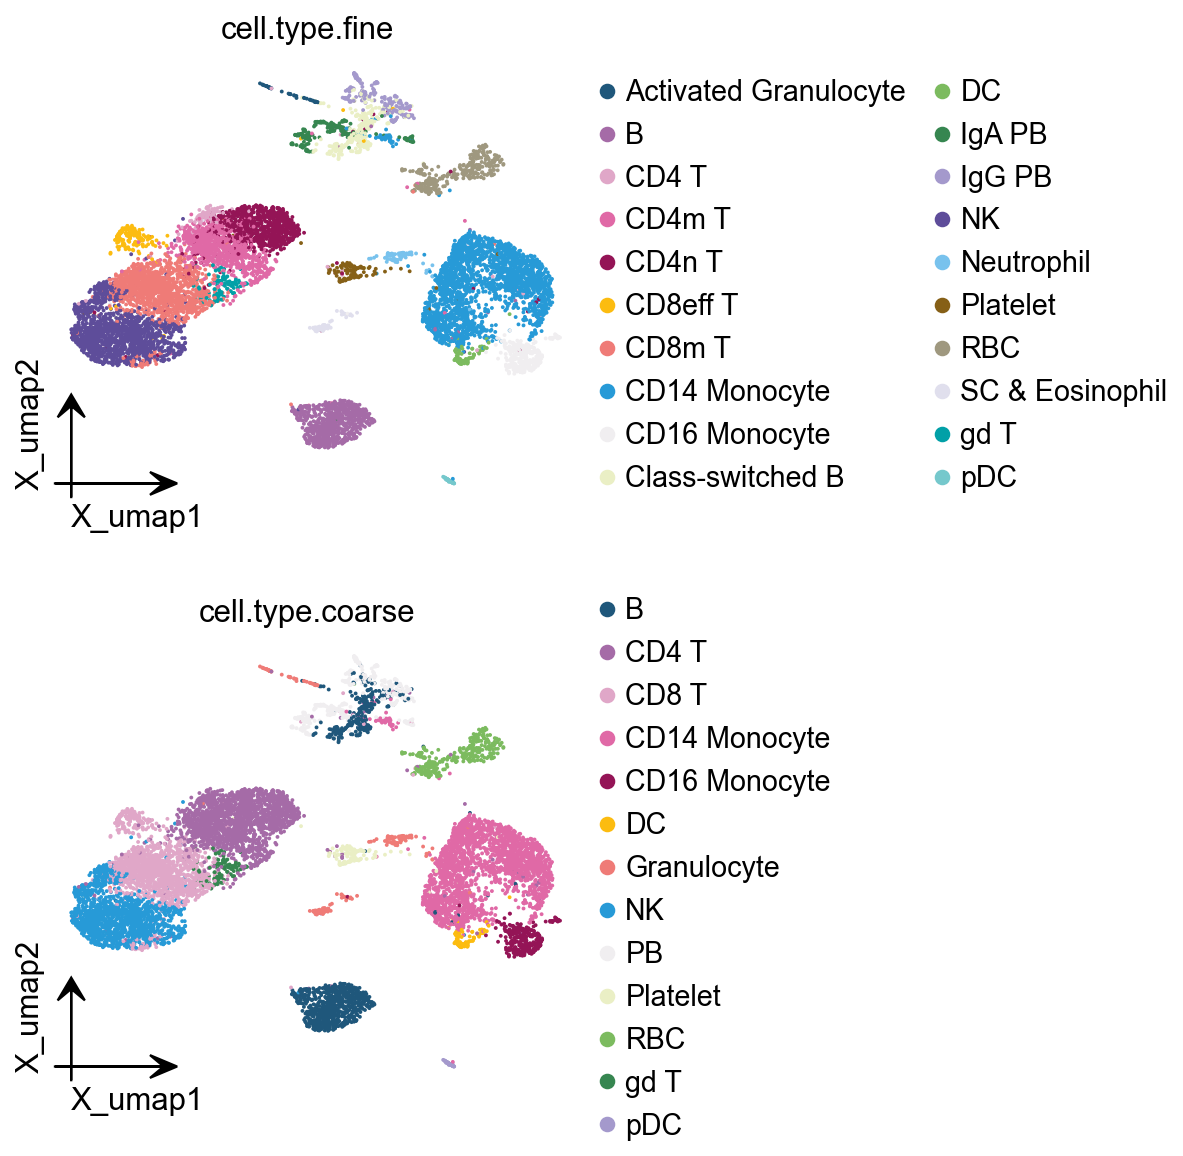

In [10]:
ov.pl.embedding(
    single_ad_ref,
    basis='X_umap',
    color=['cell.type.fine','cell.type.coarse'],
    ncols=1
)

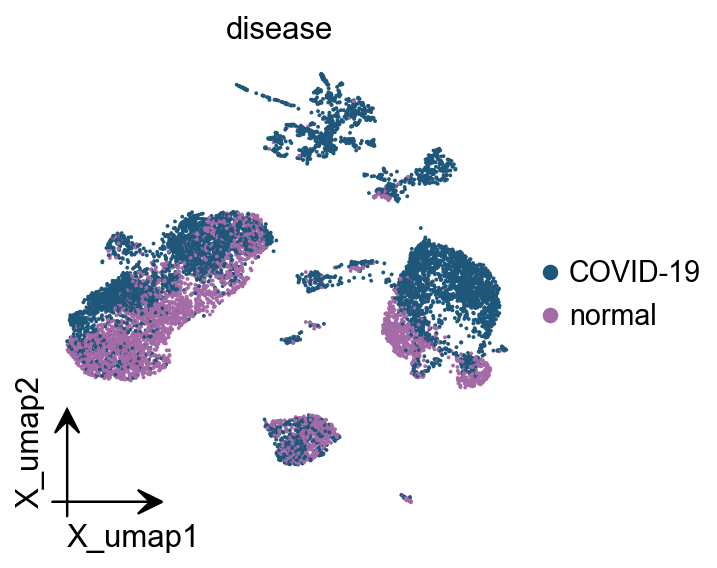

In [11]:
ov.pl.embedding(
    single_ad_ref,
    basis='X_umap',
    color='disease'
)

We can use stacked bar charts to observe the distribution of cell proportions across different groups.

In [ ]:
fig,ax=ov.plt.subplots(figsize = (1.5,3))
ov.pl.cellproportion(
    adata=single_ad_ref,
    celltype_clusters='cell.type.coarse',
    groupby='disease',legend=True,ax=ax
)

## 2. Run bayesprime

In the omicverse, all deconvolution runs are performed through the same class. This means that if new methods are added in the future, only the method parameter needs to be modified, which greatly facilitates future benchmarking.

We first need to define the input bulk RNA-seq matrix and the reference scRNA-seq matrix.

In [13]:
deconv_obj=ov.bulk.Deconvolution(
    adata_bulk=bulk_ad,
    adata_single=single_ad_ref,
    max_single_cells=10000,
    celltype_key='cell.type.coarse',
    cellstate_key='cell.type.fine',
)

......single-cell reference built finished
CUDA not available, using MPS backend instead.


<div class="admonition warning">
  <p class="admonition-title">Note</p>
  <p>
    "The key `celltype_key` and `cellstate_key` can be set as same. This parameter is only used in the Bayesprime method; other methods do not involve minor cell types."
  </p>
</div>

In [14]:
res=deconv_obj.deconvolution(
    method='bayesprism',n_cores=8,fast_mode=True
)

number of cells in each cell state
No tumor reference is speficied. Reference cell types are treated equally.
Number of outlier genes filtered from mixture = 5
Aligning reference and mixture...
Normalizing reference...
FAST MODE: Using fixed-point iteration (50-500x faster)
Note: Results are approximate (correlation >0.99 with Gibbs)
Fast deconvolution (fixed-point iteration)...
Note: 50-500x faster but approximate results (no update_gibbs)
Run fast deconvolution using fixed-point iteration (n_iter=100)...
Note: This is 50-500x faster but provides approximate results.


Fast deconvolution: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 34/34 [00:28<00:00,  1.18it/s]


  Fixed-point iteration 0: max_diff = 0.021858
  Fixed-point iteration 10: max_diff = 0.012418
  Fixed-point iteration 20: max_diff = 0.003776
  Fixed-point iteration 30: max_diff = 0.001679
  Fixed-point iteration 40: max_diff = 0.001075
  Fixed-point iteration 50: max_diff = 0.000761
  Fixed-point iteration 60: max_diff = 0.000556
  Fixed-point iteration 70: max_diff = 0.000408
  Fixed-point iteration 80: max_diff = 0.000300
  Fixed-point iteration 90: max_diff = 0.000263

Completed in 29.16 seconds
  Samples: 34
  Converged: 0/34 (0.0%)
  Average iterations: 100.0
  Time per sample: 857.66 ms
Merging cell states to cell types...


<div class="admonition warning">
  <p class="admonition-title">Note</p>
  <p>
    It is important to note that when we set the `fast_mode` parameter to True, we are actually invoking InstaPrime. In fact, the similarity between the two is as high as 0.99. If you wish to invoke BayesPrime, simply set `fast_mode=False`.
  </p>
</div>

In [20]:
res=res[single_ad_ref.obs['cell.type.coarse'].cat.categories]
res.head()

B     CD4 T     CD8 T  CD14 Monocyte  \
S145_nCOV001_C           0.007152  0.045643  0.028839       0.350588   
S147_nCoV001EUHM-Draw-1  0.042290  0.064573  0.145169       0.207204   
S149_nCoV002EUHM-Draw-2  0.044652  0.002136  0.026601       0.435803   
S150_nCoV003EUHM-Draw-1  0.016705  0.004011  0.105450       0.345644   
S151_nCoV004EUHM-Draw-1  0.029047  0.000164  0.037455       0.610666   

                         CD16 Monocyte        DC  Granulocyte        NK  \
S145_nCOV001_C                0.358540  0.063780     0.005991  0.102774   
S147_nCoV001EUHM-Draw-1       0.209637  0.064921     0.014626  0.176877   
S149_nCoV002EUHM-Draw-2       0.268785  0.032620     0.017837  0.083378   
S150_nCoV003EUHM-Draw-1       0.154792  0.024709     0.012880  0.160400   
S151_nCoV004EUHM-Draw-1       0.127016  0.009614     0.009160  0.023490   

                               PB  Platelet           RBC      gd T       pDC  
S145_nCOV001_C           0.003153  0.019414  2.157114e-05  0.000909  0.013197  
S147_nCoV001EUHM-Draw-1  0.046780  0.014637  1.785132e-10  0.003598  0.009689  
S149_nCoV002EUHM-Draw-2  0.048856  0.034941  1.004674e-09  0.000243  0.004149  
S150_nCoV003EUHM-Draw-1  0.152966  0.018139  5.689293e-04  0.000129  0.003605  
S151_nCoV004EUHM-Draw-1  0.087138  0.062375  2.029203e-03  0.000016  0.001830

To maintain consistency in the color representation of single-cell cell types, we need to redefine color_dict.

In [21]:
color_dict=dict(zip(
    single_ad_ref.obs['cell.type.coarse'].cat.categories,
    single_ad_ref.uns['cell.type.coarse_colors']
))

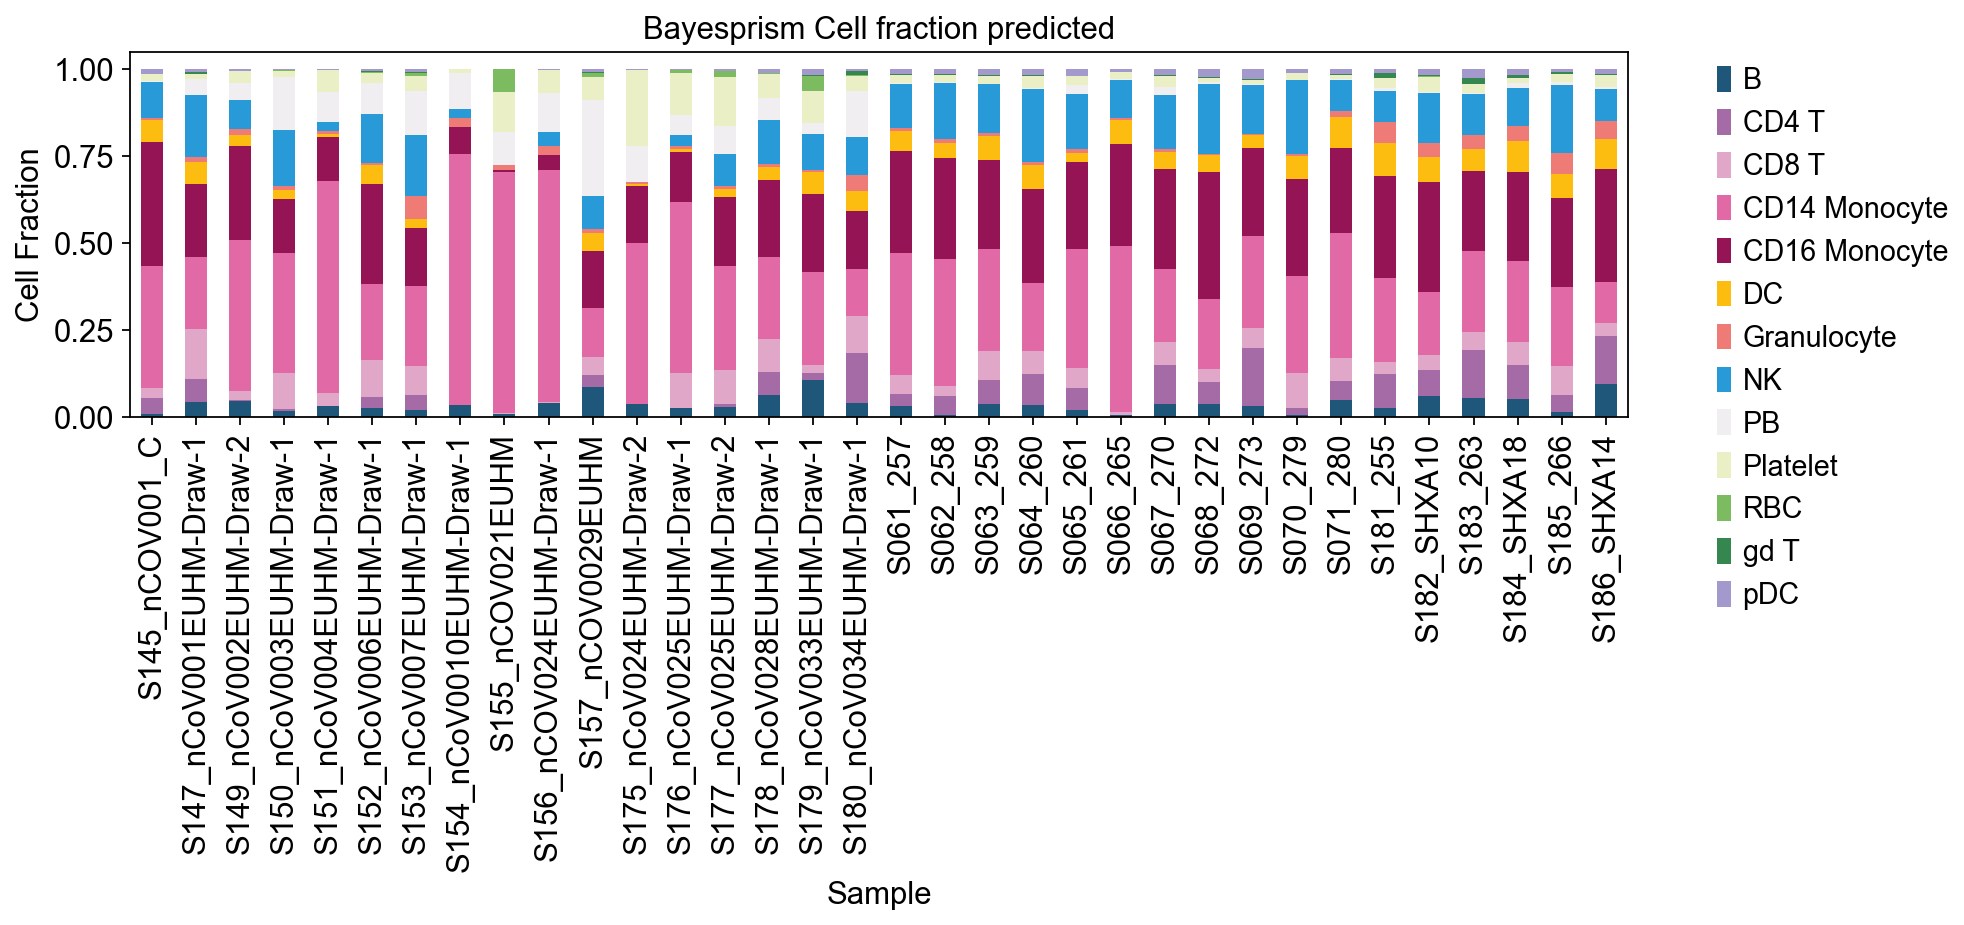

In [22]:
ax = res.plot(kind='bar', stacked=True, figsize=(12, 3),color=color_dict)
ax.set_xlabel('Sample')
ax.set_ylabel('Cell Fraction')
#ax.set_xticklabels([])
ax.set_title('Bayesprism Cell fraction predicted')
ov.plt.legend(bbox_to_anchor=(1.05, 1),ncol=1,)
ov.plt.show()

<Axes: title={'center': 'Cell fractions grouped by disease_state (mean)'}, xlabel='disease_state', ylabel='Cell Fraction'>

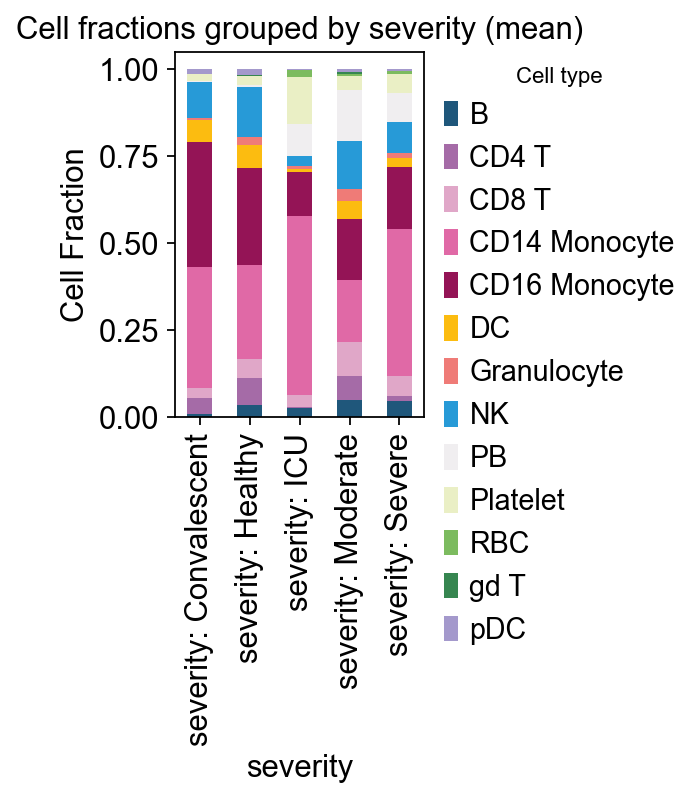

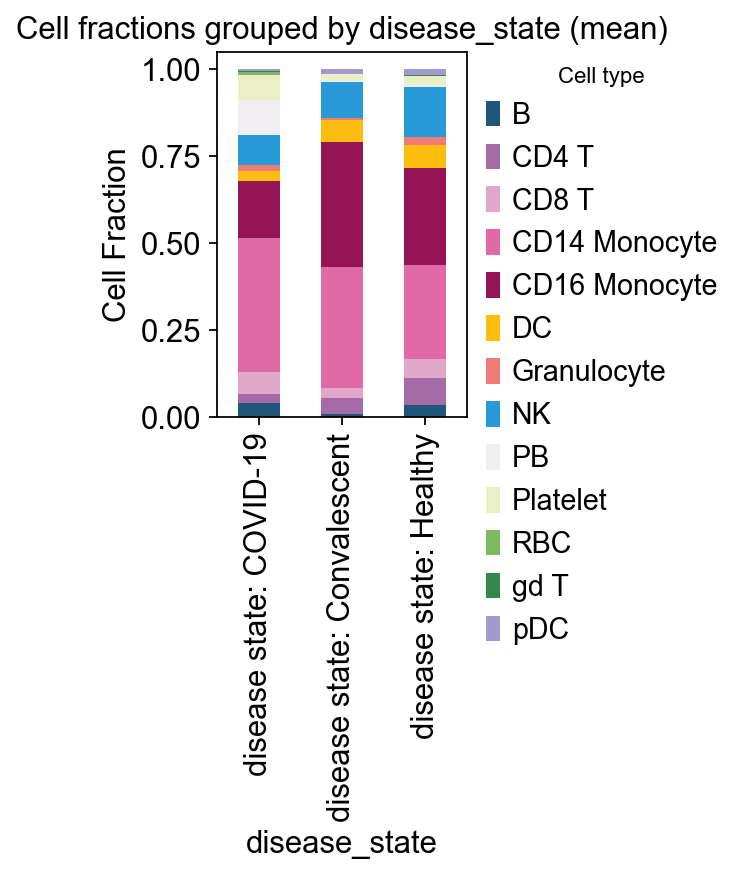

In [35]:
# example: severity
ov.pl.plot_grouped_fractions(
    res, bulk_ad.obs, group_key='severity',
    color_dict=color_dict, agg='mean', normalize=True,
    figsize=(2,3)
)

# example: disease_state
ov.pl.plot_grouped_fractions(
    res, bulk_ad.obs, group_key='disease_state', 
    color_dict=color_dict, agg='mean', normalize=True,
    figsize=(2,3)
)


## 3. Run Scaden

Scaden is a tool for bulk RNA-seq cell type deconvolutional that uses a deep neural network ensemble trained on artificial bulk data simulated with scRNA-seq datasets.

Similar to BayesPrime, we also use the same deconvolution class when running scaden.

In [37]:
deconv_obj=ov.bulk.Deconvolution(
    adata_bulk=bulk_ad,
    adata_single=single_ad_ref,
    max_single_cells=10000,
    celltype_key='cell.type.coarse',
    cellstate_key='cell.type.fine',
    gpu='mps'
)

......single-cell reference built finished
Using Apple Metal Performance Shaders (MPS) backend.


<div class="admonition warning">
  <p class="admonition-title">Note</p>
  <p>
   Since Scaden is a deep learning-based approach, we need to configure the device for running torch, including Nvidia's CUDA, Apple's MPS, or running directly on the CPU.
  </p>
</div>

Compared to BayesPrime, scaden requires more parameters to configure, including scaler, scale, and datatype. For scaler, this determines how we normalize the pseudobulk generated from single-cell reads and the actual bulk data. Scale, however, indicates whether we need to perform min-max normalization on the data before feeding it into the scaler.

Reading single-cell dataset, this may take 1 min
Reading dataset is done
Normalizing raw single cell data with scanpy.pp.normalize_total
Generating cell fractions using Dirichlet distribution without prior info (actually random)
RANDOM cell fractions is generated
You set sparse as True, some cell's fraction will be zero, the probability is 0.5
Sampling cells to compose pseudo-bulk data


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2000/2000 [00:09<00:00, 208.90it/s]


Sampling is done
Reading training data
Reading is done
Reading test data
Reading test data is done
Using counts data to train model
Cutting variance...
Finding intersected genes...
Intersected gene number is  23734
Scaling...


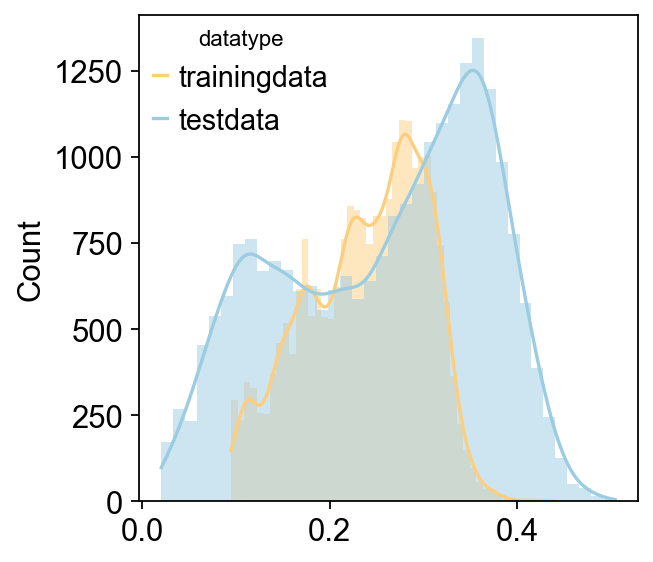

Using standard scaler...


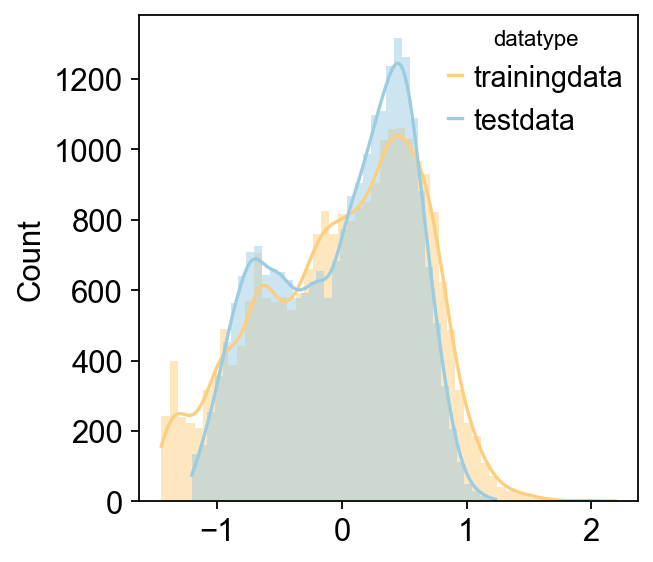

training data shape is  (2000, 23734) 
test data shape is  (34, 23734)
train model256 now


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 128/128 [00:53<00:00,  2.38it/s]


train model512 now


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 128/128 [01:39<00:00,  1.29it/s]


train model1024 now


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 128/128 [03:45<00:00,  1.77s/it]


Training of Scaden is done


In [38]:
res2=deconv_obj.deconvolution(
    method='scaden',scaler='ss',scale=True,datatype='counts',
    pseudobulk_size=2000,
)

<div class="admonition warning">
  <p class="admonition-title">Note</p>
  <p>
   It is crucial to note that while the original implementation of scaden supports TPM, RPKM, and similar metrics, we strongly recommend using raw count data to ensure algorithm consistency.
  </p>
</div>

In [39]:
res2=res2[single_ad_ref.obs['cell.type.coarse'].cat.categories]

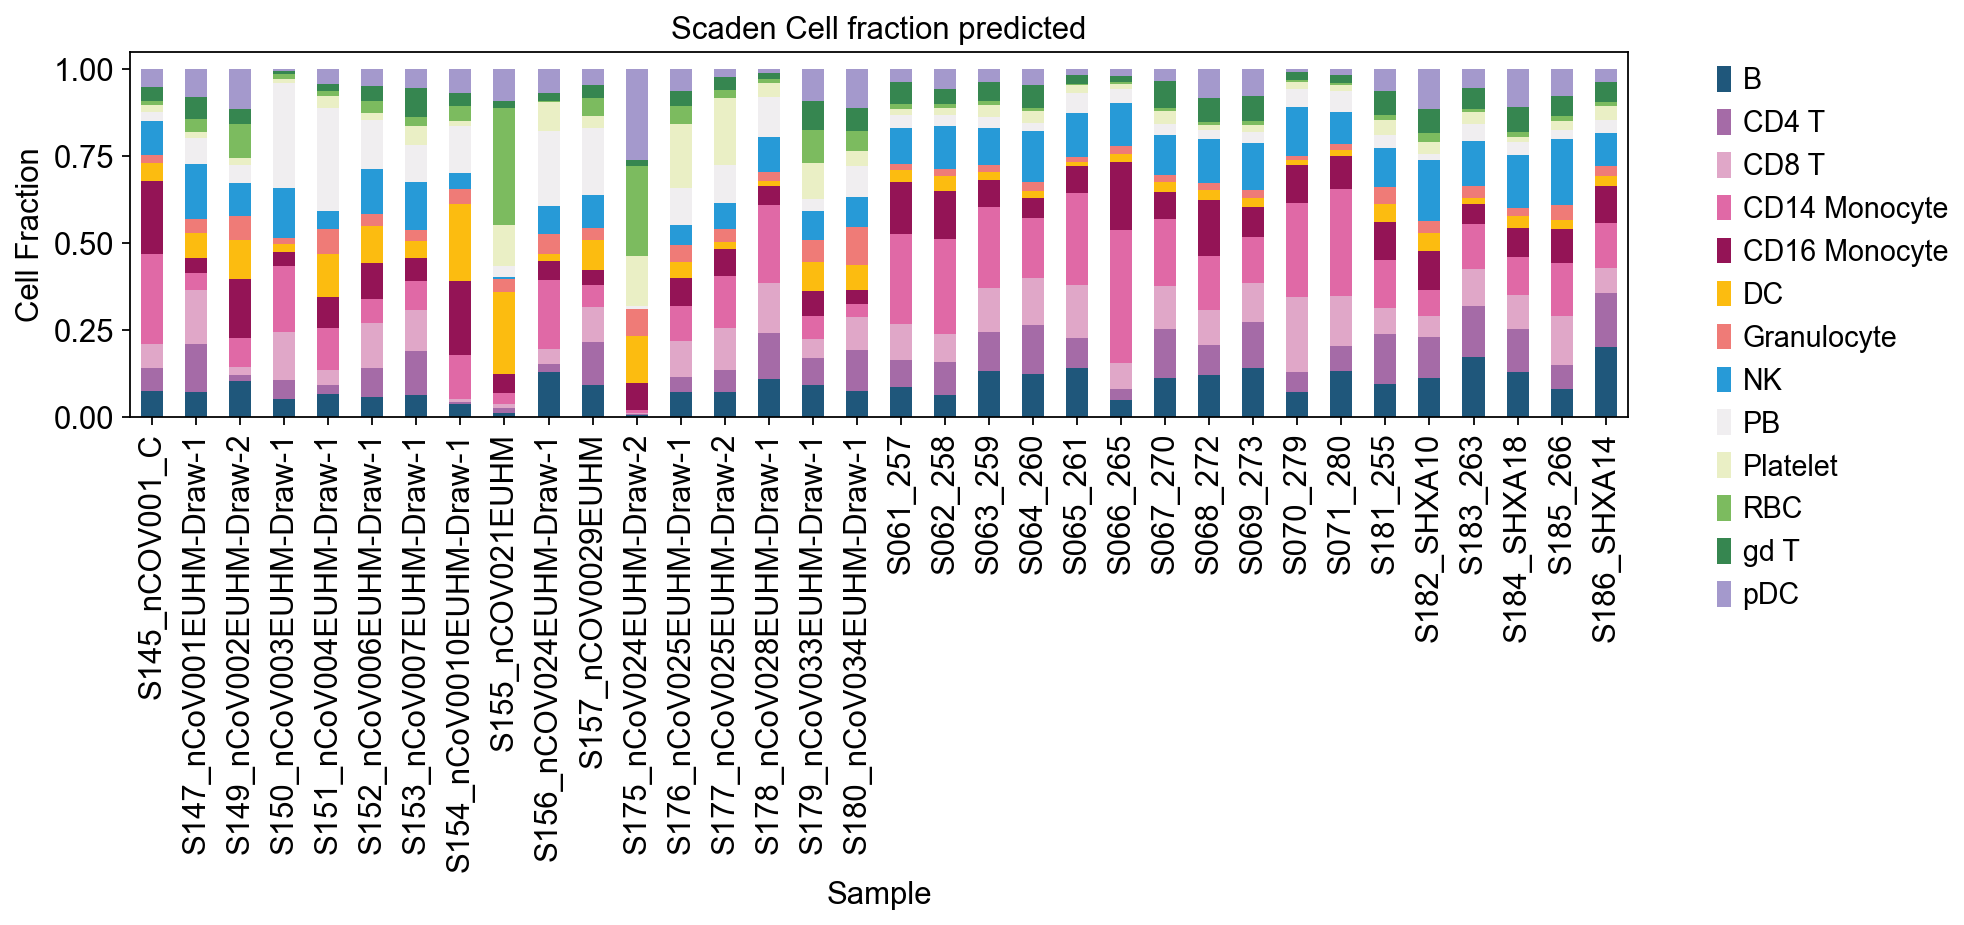

In [40]:
ax = res2.plot(kind='bar', stacked=True, figsize=(12, 3),color=color_dict)
ax.set_xlabel('Sample')
ax.set_ylabel('Cell Fraction')
#ax.set_xticklabels([])
ax.set_title('Scaden Cell fraction predicted')
ov.plt.legend(bbox_to_anchor=(1.05, 1),ncol=1,)
ov.plt.show()

<Axes: title={'center': 'Cell fractions grouped by disease_state (mean)'}, xlabel='disease_state', ylabel='Cell Fraction'>

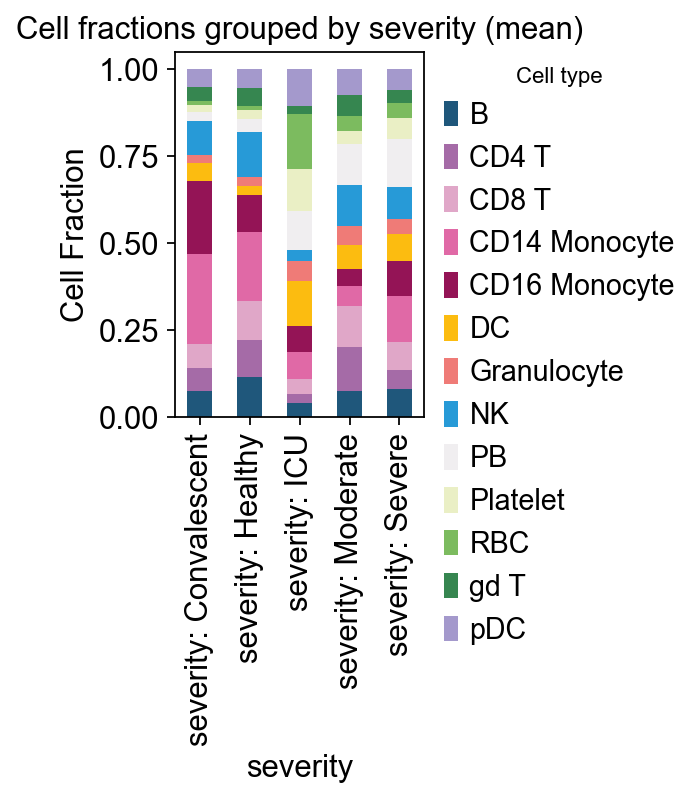

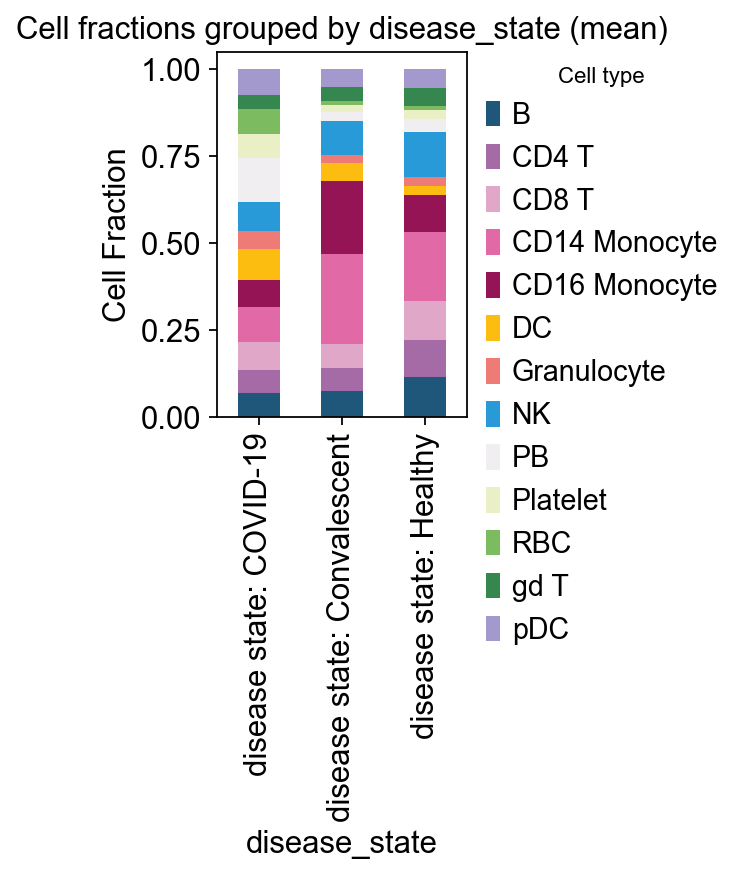

In [41]:
# example: severity
ov.pl.plot_grouped_fractions(
    res2, bulk_ad.obs, group_key='severity',
    color_dict=color_dict, agg='mean', normalize=True,
    figsize=(2,3)
)

# example: disease_state
ov.pl.plot_grouped_fractions(
    res2, bulk_ad.obs, group_key='disease_state', 
    color_dict=color_dict, agg='mean', normalize=True,
    figsize=(2,3)
)
